# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Note: there may be minor differences between the output of this notebook and the examples shown in the book. You can safely ignore these differences. They are mainly due to the fact that most of the environments provided by OpenAI gym have some randomness.

# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [45]:
import gym
import tensorflow as tf

def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,    

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

To code our first learning agent, we will be using a simpler environment: the Cart-Pole. 

# Learning to Play MsPacman Using the DQN Algorithm

**Warning**: Unfortunately, the first version of the book contained two important errors in this section.

1. The actor DQN and critic DQN should have been named _online DQN_ and _target DQN_ respectively. Actor-critic algorithms are a distinct class of algorithms.
2. The online DQN is the one that learns and is copied to the target DQN at regular intervals. The target DQN's only role is to estimate the next state's Q-Values for each possible action. This is needed to compute the target Q-Values for training the online DQN, as shown in this equation:

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

* $y(s,a)$ is the target Q-Value to train the online DQN for the state-action pair $(s, a)$.
* $r$ is the reward actually collected after playing action $a$ in state $s$.
* $\gamma$ is the discount rate.
* $s'$ is the state actually reached after played action $a$ in state $s$.
* $a'$ is one of the possible actions in state $s'$.
* $Q_\text{target}(s', a')$ is the target DQN's estimate of the Q-Value of playing action $a'$ while in state $s'$.


## Creating the MsPacman environment

In [5]:
# Load the MsPacman evironment, version 0
env = gym.make("MsPacman-v0")
# Initialize the evironment by calling its reset() method
obs = env.reset() 
# The observation here is an RGB image represented as a 3D NumPy array 
# of shape [width, height, channels] (with 3 channels: Red, Green and Blue) 
obs.shape

(210, 160, 3)

In [6]:
# The possible actions are integers 0 through 8, 
# which represents the 9 possible positions of the joystick 
# (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left)
env.action_space

Discrete(9)

## Preprocessing

Preprocessing the images is optional but greatly speeds up training.

In [7]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

Note: the `preprocess_observation()` function is slightly different from the one in the book: instead of representing pixels as 64-bit floats from -1.0 to 1.0, it represents them as signed bytes (from -128 to 127). The benefit is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB). The reduced precision has no visible impact on training.

<IPython.core.display.Javascript object>


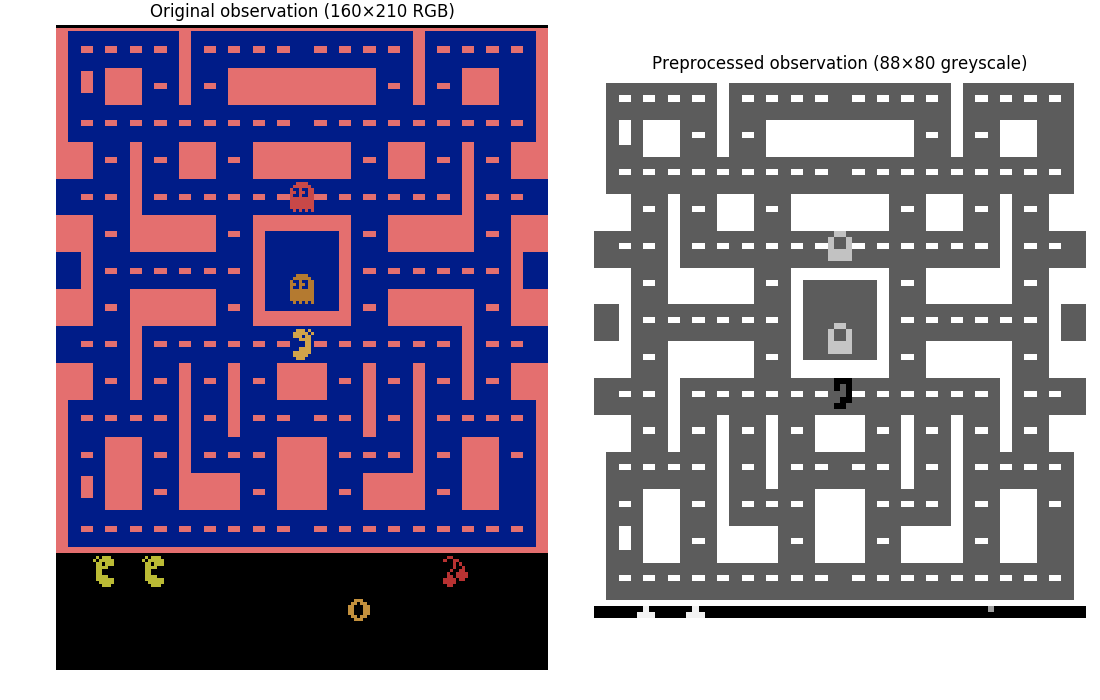

Saving figure preprocessing_plot


In [8]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

**Question:** Why will the preprocessing help to speed up training?

## Build DQN

Now, let's create the DQN as seen in today's lecture slides. It could just take a state-action pair _(s,a)_ as input, and output an estimate of the corresponding Q-Value _Q(s,a)_. However, since the actions are discrete, it is more conveinient to use a neural network that takes only a state _s_ as input and outputs one Q-Value estimate per action. The DQN will be composed of three convolutional layers, followed by two fully connected layers, including the output layer.

Note: instead of using `tf.contrib.layers.convolution2d()` or `tf.contrib.layers.conv2d()` (as in the first version of the book), we now use the `tf.layers.conv2d()`, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same, except that the parameter names have changed slightly:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the `_fn` suffix was removed from parameter names that had it (e.g., `activation_fn` was renamed to `activation`),
* the `weights_initializer` parameter was renamed to `kernel_initializer`,
* the weights variable was renamed to `"kernel"` (instead of `"weights"`), and the biases variable was renamed from `"biases"` to `"bias"`,
* and the default `activation` is now `None` instead of `tf.nn.relu`.

As we will see, the training algorithm we will use requires two DQNs with the same architecture (but different parameters): one will be used to learn during training (the online DQN), and the other will be used to estimate the next state's Q-Values for each possible action (the target DQN). At regular intervals we will copy the online DQN to the target DQN. Since we need two identical DQNs, we will create a q_network() function to build them:

In [14]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

The first part of this code defines the hyperparameters of the DQN architecture.
Then the q_network() function creates the DQN, taking the environment’s state
X_state as input, and the name of the variable scope. Note that we will just use one 
observation to represent the environment’s state since there’s almost no hidden state
(except for blinking objects and the ghosts’ directions).

The trainable_vars_by_name dictionary gathers all the trainable variables of this
DQN. It will be useful in a minute when we create operations to copy the online DQN
to the target DQN. The keys of the dictionary are the names of the variables, stripping
the part of the prefix that just corresponds to the scope’s name. 

**Question:** Print out the trainable_vars_by_name dictionary. Do the variables reflect the full structure of the network?

Now let’s create the input placeholder, the two DQNs, and the operation to copy the online DQN to the target DQN:

In [15]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

**Question:** How do the online_vars compare to the target_vars at this point?

Let’s step back for a second: we now have two DQNs that are both capable of taking
an environment state (i.e., a preprocessed observation) as input and outputting an
estimated Q-Value for each possible action in that state. Plus we have an operation
called copy_online_to_target to copy all the trainable variables of the online DQN to
the target DQN. We use TensorFlow’s tf.group() function to group all the assignment operations into a single convenient operation.

The online DQN can be used to play Ms. Pac-Man (initially very badly). As discussed
earlier, you want it to explore the game thoroughly enough, so you generally want to
combine it with an ε-greedy policy or another exploration strategy.

But what about the target DQN? How will it learn to play the game? The short answer
is that it will try to make its Q-Value predictions match the Q-Values estimated by the
online DQN through its experience of the game. Specifically, we will let the online DQN play for a
while, storing all its experiences in a replay memory. Each memory will be a 5-tuple
(state, action, next state, reward, continue), where the “continue” item will be equal to
0.0 when the game is over, or 1.0 otherwise. Next, at regular intervals we will sample a batch of memories from the replay memory, and we will estimate the Q-Values from
these memories. Finally, we will train the target DQN to predict these Q-Values using
regular supervised learning techniques. Once every few training iterations, we will
copy the online DQN to the target DQN.

In [16]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

**Question** Explain at a high level what the above block of code is doing. \[_Hint: it has to do with the target DQN._\]

Note: in the first version of the book, the loss function was simply the squared error between the target Q-Values (`y`) and the estimated Q-Values (`q_value`). However, because the experiences are very noisy, it is better to use a quadratic loss only for small errors (below 1.0) and a linear loss (twice the absolute error) for larger errors, which is what the code above computes. This way large errors don't push the model parameters around as much. Note that we also tweaked some hyperparameters (using a smaller learning rate, and using Nesterov Accelerated Gradients rather than Adam optimization, since adaptive gradient algorithms may sometimes be bad, according to this [paper](https://arxiv.org/abs/1705.08292)). We also tweaked a few other hyperparameters below (a larger replay memory, longer decay for the $\epsilon$-greedy policy, larger discount rate, less frequent copies of the online DQN to the target DQN, etc.).

That’s it for the construction phase. Before we look at the execution phase, we will need a couple of tools. First, let’s start by implementing the replay memory.

We use this `ReplayMemory` class instead of a `deque` because it is much faster for random access (thanks to @NileshPS who contributed it). Moreover, we default to sampling with replacement, which is much faster than sampling without replacement for large replay memories.

In [17]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [18]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [19]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

Next, we will need the online DQN to explore the game. We will use an ε-greedy policy:

In [20]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

That’s it! We have all we need to start training.

The execution phase does not contain
anything too complex, but it is a bit long, so take a deep breath. Ready? Let’s go! First,
let’s initialize a few variables:

In [35]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

A few variables for tracking progress:

In [36]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

And now the main training loop!

In [ ]:
import time
import datetime


with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    
    tic = time.clock()
    currentDT = datetime.datetime.now()
    print( "time started: " + str(currentDT) )
    
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)
            
    toc = time.clock()
    
    print("time taken ", toc-tic )

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
time started: 2019-04-21 20:15:55.512550
Iteration 176168	Training step 52001/4000000 (1.3)%	Loss 0.760949	Mean Max-Q 0.460539   

/home/janelle/Documents/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


Iteration 2777556	Training step 702348/4000000 (17.6)%	Loss 3.426302	Mean Max-Q 70.941578    

You can interrupt the cell above at any time to test your agent using the cell below. You can then run the cell above once again, it will load the last parameters saved and resume training.

In [38]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


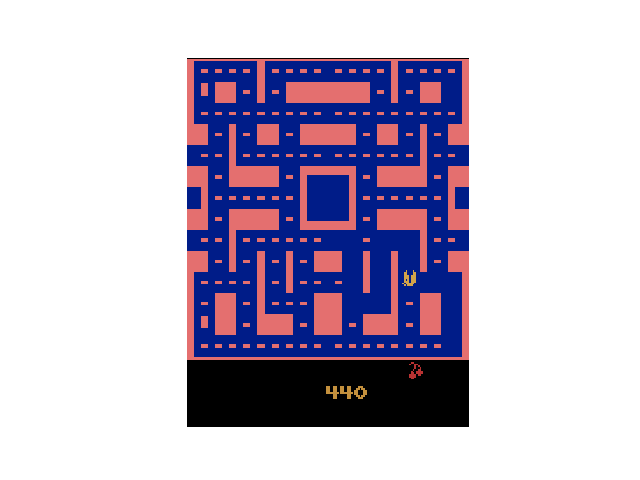

In [46]:
plot_animation(frames)

**Question** How well does your agent perform? How do you think you could improve its performance?

## Preprocessing for Breakout

Here is a preprocessing function you can use to train a DQN for the Breakout-v0 Atari game:

In [73]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [74]:
env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

[2017-09-25 13:54:27,989] Making new env: Breakout-v0


<IPython.core.display.Javascript object>


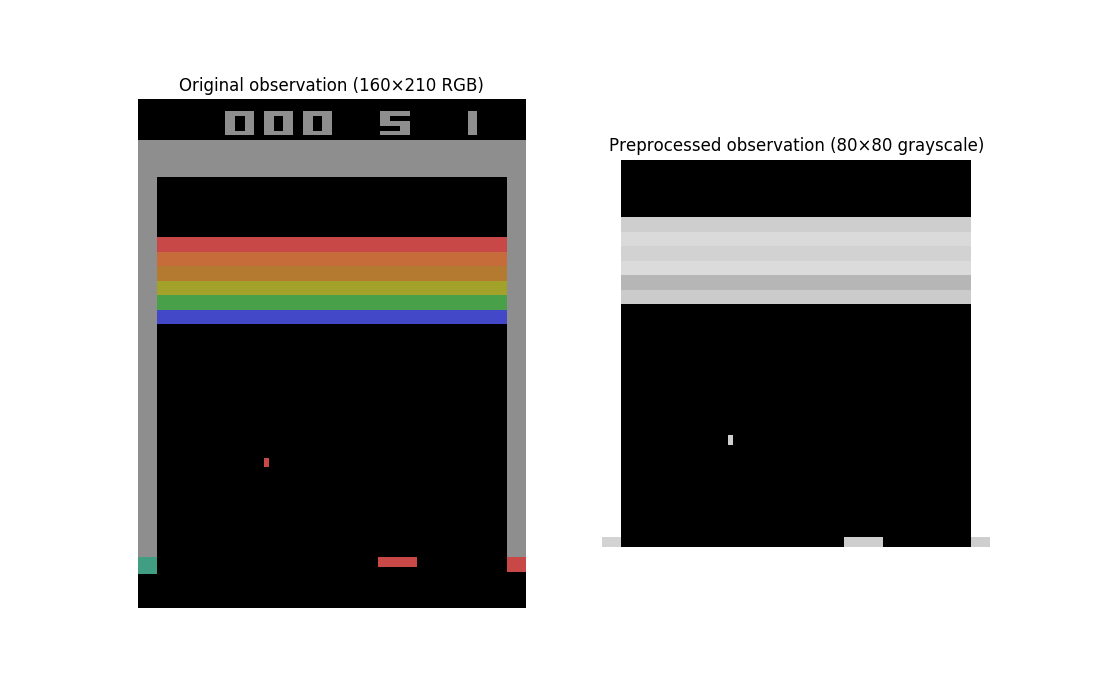

In [75]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

As you can see, a single image does not give you the direction and speed of the ball, which are crucial informations for playing this game. For this reason, it is best to actually combine several consecutive observations to create the environment's state representation. One way to do that is to create a multi-channel image, with one channel per recent observation. Another is to merge all recent observations into a single-channel image, using `np.max()`. In this case, we need to dim the older images so that the DQN can distinguish the past from the present.

In [76]:
from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

<IPython.core.display.Javascript object>


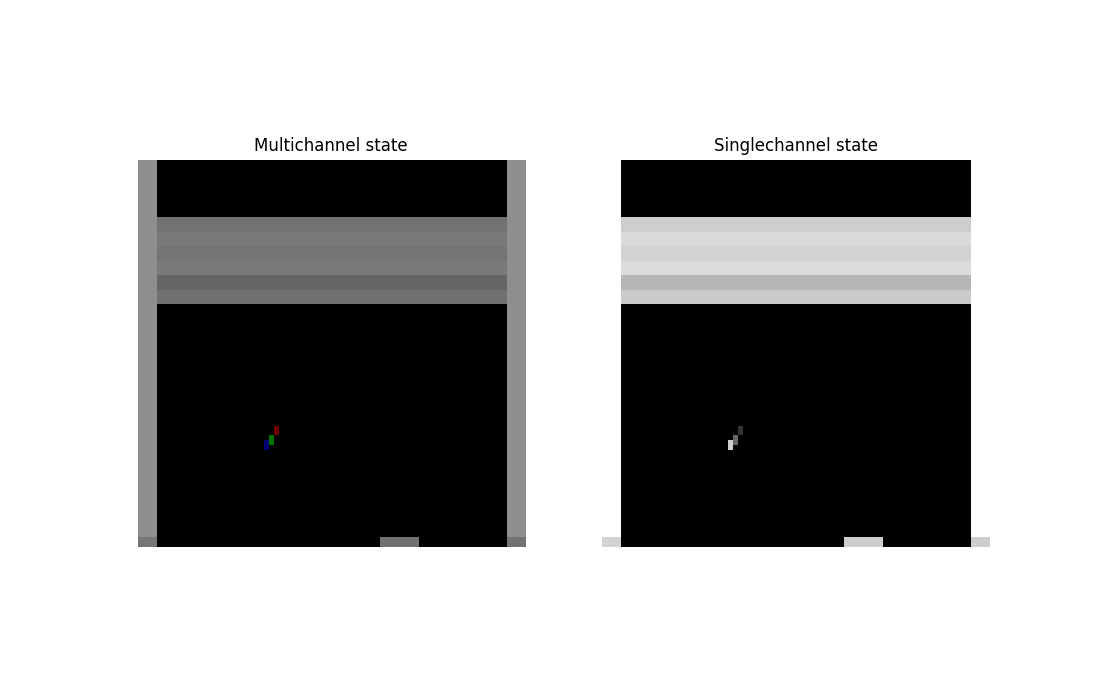

In [77]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

**Question:** Why do you think having multiple observations for a state will perform better?